In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

OUT_PATH = "../out/"

def plot_results(points, bound):
    x = points['k'].to_numpy()
    y = points['value'].to_numpy()

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Plot the density
    ax.hist2d(x, y, bins=[x.max()-x.min(), 500], range=[[x.min() - 1, x.max()], [0, y.max()]], cmap='inferno', norm='log')

    # Plot a line on top of the density plot
    line_x = bound['k'].to_numpy()
    line_y = bound['value'].to_numpy()
    ax.plot(line_x, line_y, color='red', linewidth=0.5)

    # Set labels and title
    ax.set_xlabel('k')
    ax.set_ylabel(r'$||X^\dag|| / ||X_S^\dag||$')
    ax.set_title('')

    plt.show()
    



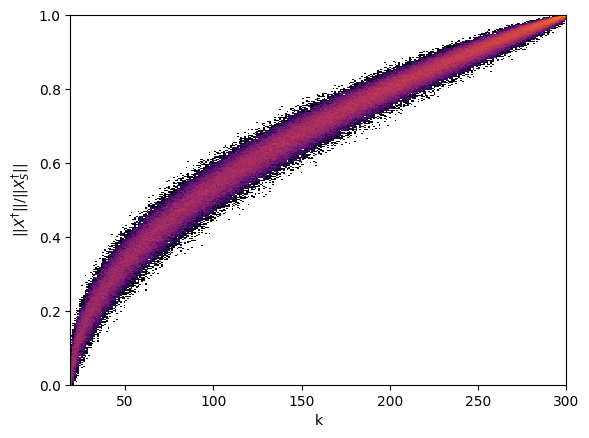

In [100]:
points = pd.read_csv(OUT_PATH + "random_1000/points.csv")
bound = pd.read_csv(OUT_PATH + "random_1000/bound.csv")

plot_results(points, bound)